## Learning task

I trained a CNN that maps DNA sequence onto observed read depth. 

## Degree of convergence of optimization process

Let's look at the cost associated with predictions that the model made on the training and dev sets:  

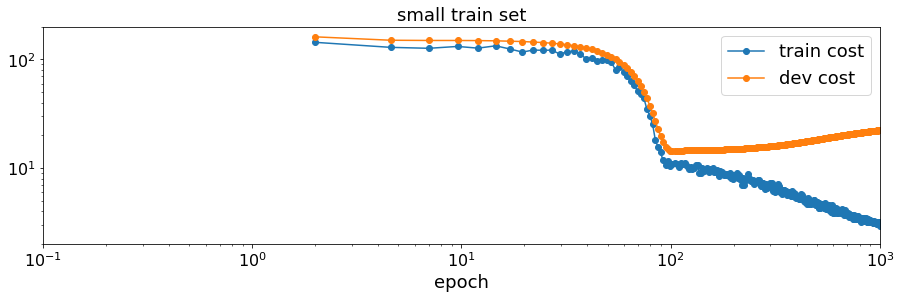

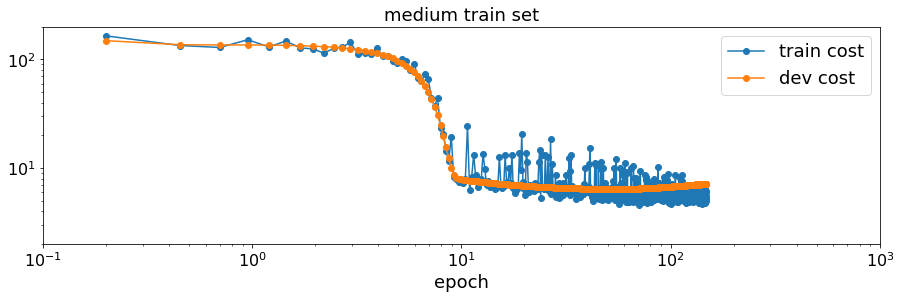

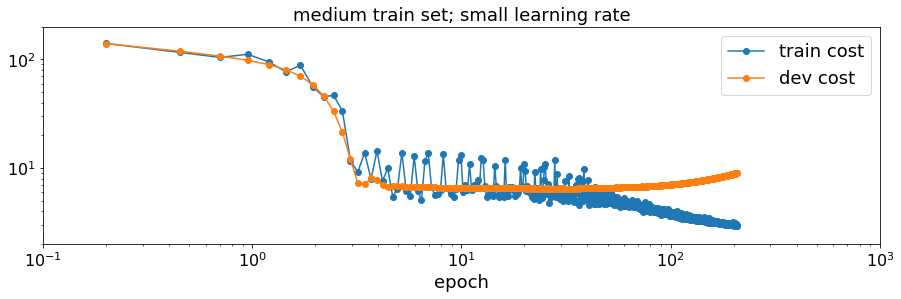

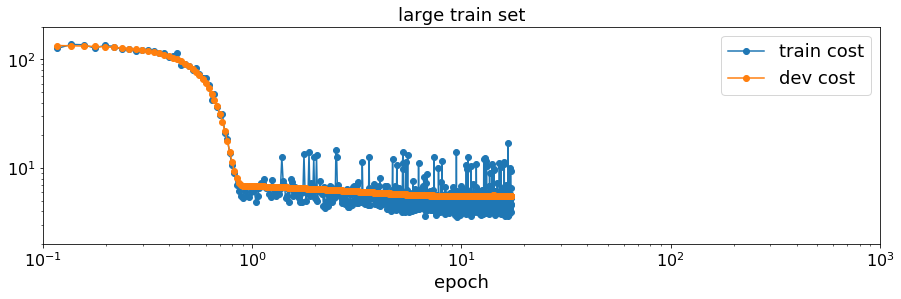

In [1]:
trained_models = [{'path': '../data/trained_models/00_new/', 'annotation': 'small train set'},
                  {'path': '../data/trained_models/01_new/', 'annotation': 'medium train set'},
                  {'path': '../data/trained_models/01_new_new/', 'annotation': 'medium train set; small learning rate'},
                  {'path': '../data/trained_models/02_large_learning_rate/', 'annotation': 'large train set'}]

%matplotlib inline 
from plot import plot_costs_all
plot_costs_all(trained_models)

**Good news**: Dev cost seems to track train cost down to lower values for larger training sets. 

## Bias-variance analysis

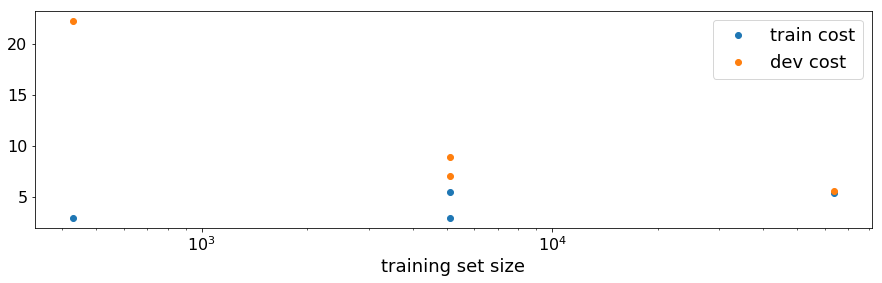

In [2]:
from plot import plot_costs_versus_training_size
plot_costs_versus_training_size(trained_models)

The divergence of train and dev costs in the smaller training set is symptomatic of overfitting. 


## Denoising read-depth profiles 

In the following, "corrected depth" is the observed depth divided by predicted depth whereas "normalized depth" is the observed depth divided by mean depth. 

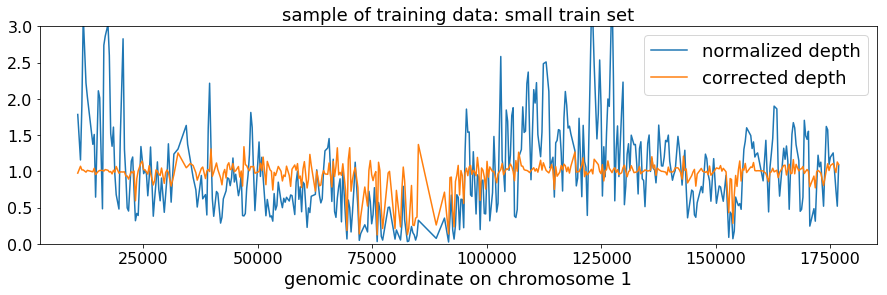

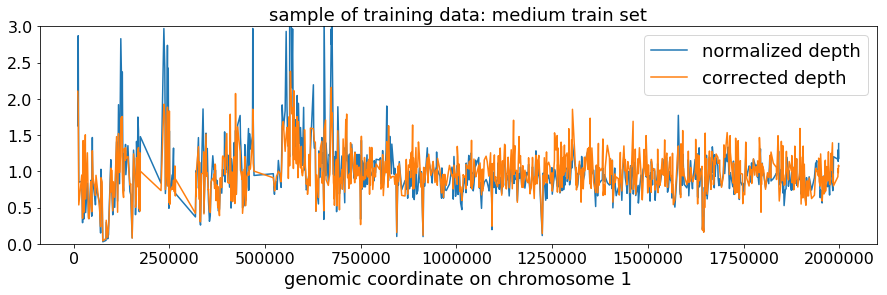

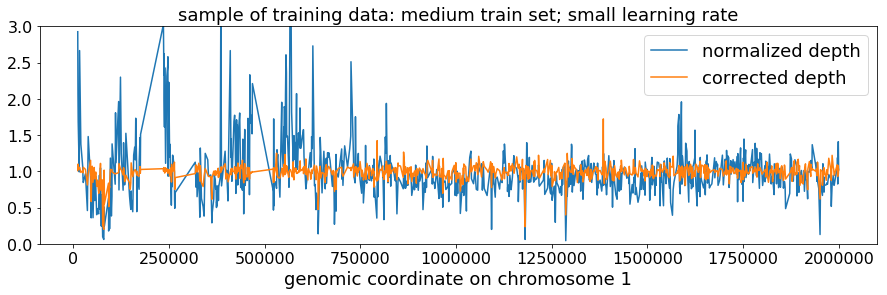

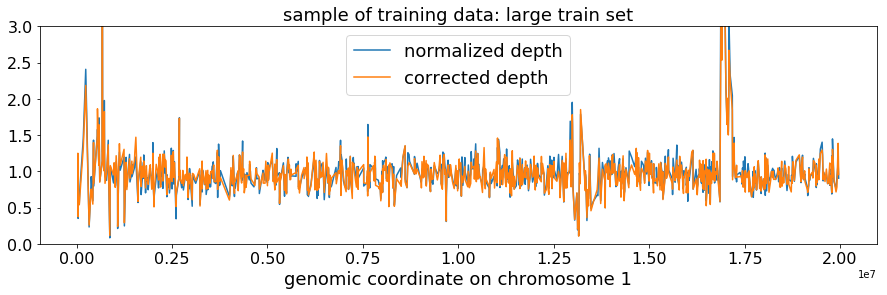

In [3]:
from plot import plot_corrected_depths_train_all
plot_corrected_depths_train_all(trained_models)

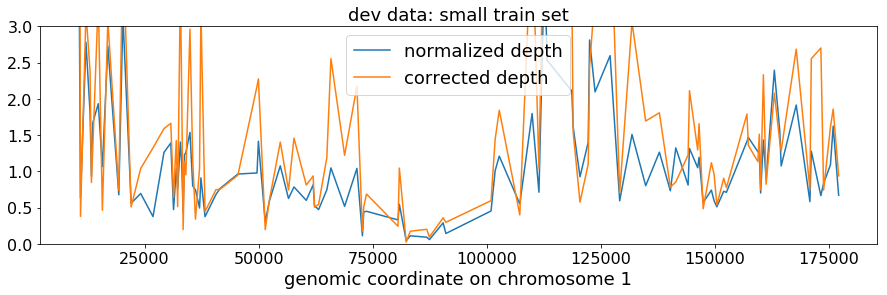

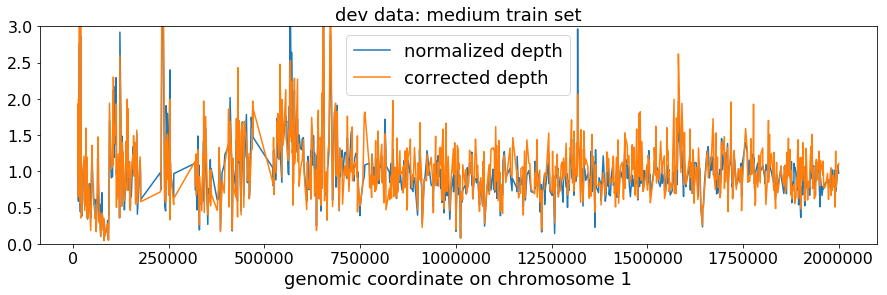

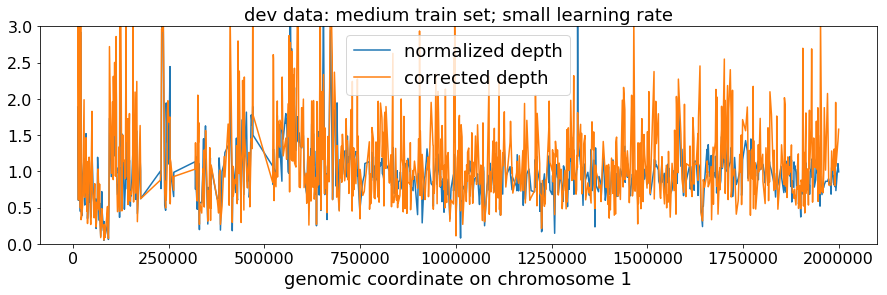

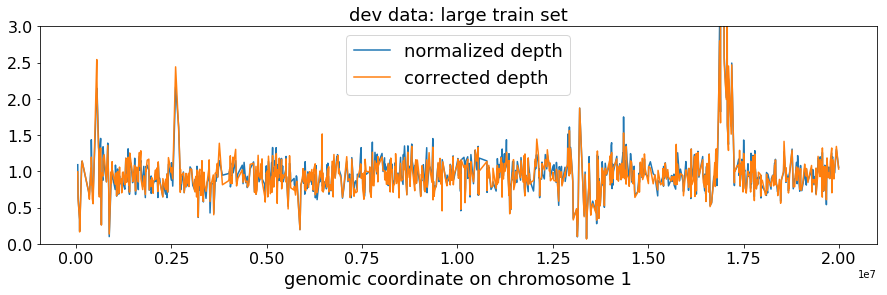

In [4]:
from plot import plot_corrected_depths_dev_all
plot_corrected_depths_dev_all(trained_models)

## Denoising a test set containing a structural variation

I used the trained model to make predictions on an independent test set containing a chromosomal deletion: 

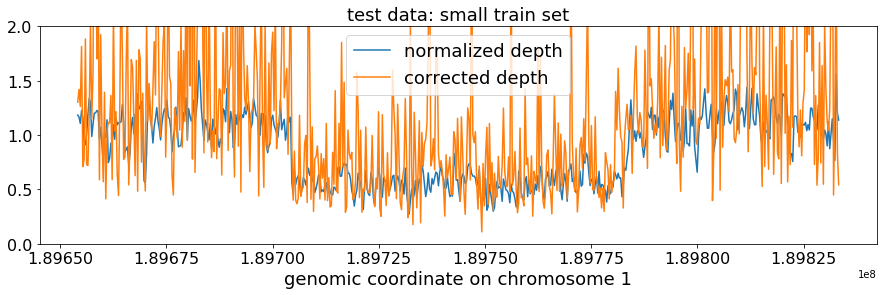

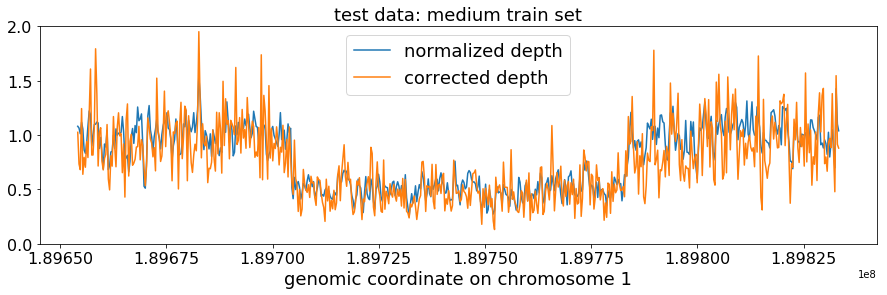

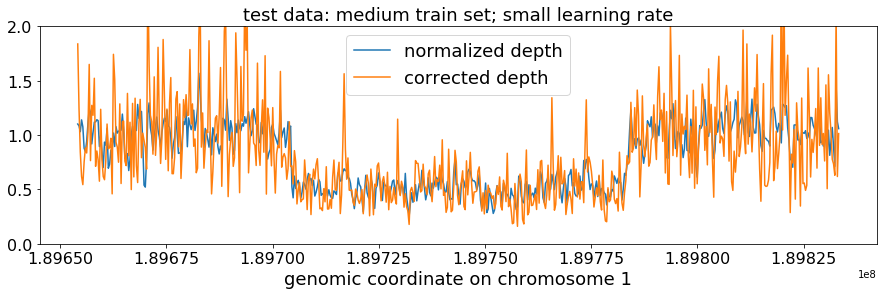

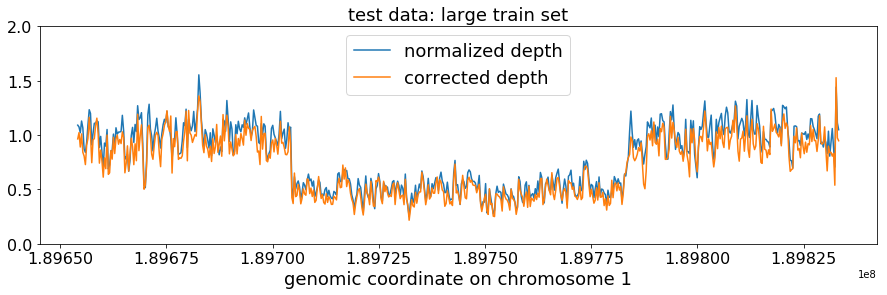

In [5]:
from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models)

## Observed versus predicted depths

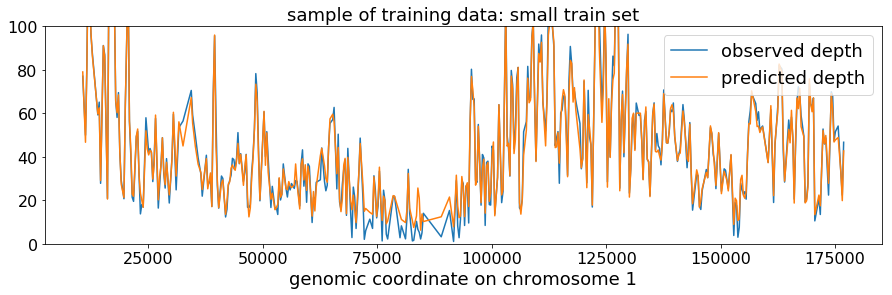

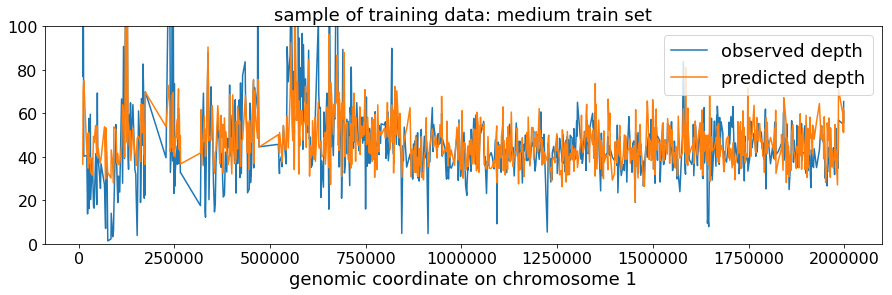

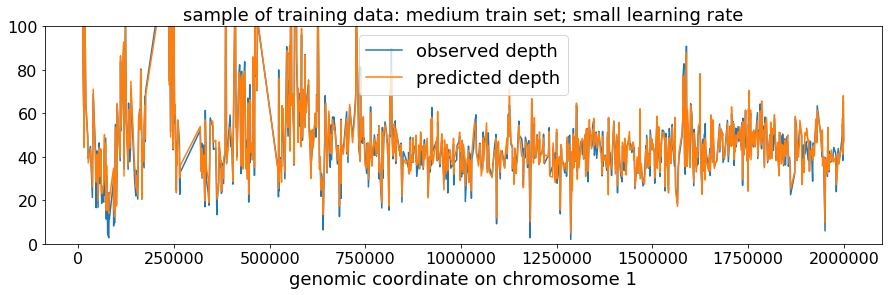

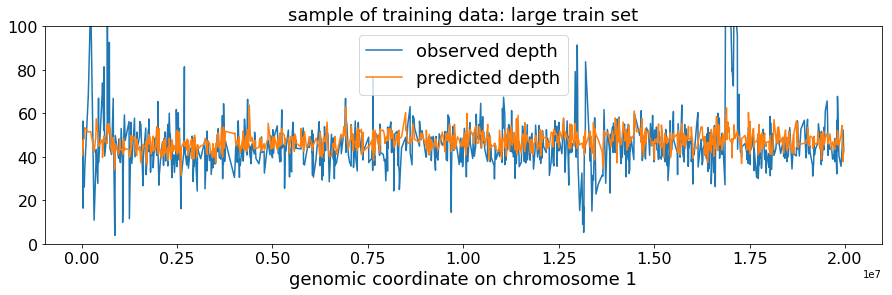

In [6]:
from plot import plot_depths_train_all
plot_depths_train_all(trained_models)